<a href="https://colab.research.google.com/github/lawrencejesse/Sentinel2_Extractor/blob/main/Reclamation_Assessment_Z_Score_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reclamation Assessment using Z-Score Transformed NDVI (Enhanced)

## Overview
This enhanced notebook analyzes crop growth within lease boundaries compared to the background field using z-score transformation of NDVI rasters. You can now choose between:
- **Robust Z-Score**: Uses median and MAD (resistant to outliers)
- **Normal Z-Score**: Uses mean and standard deviation (better for uniform data)

## Key Features
1. **Automatic Distribution Analysis**: Tests data normality and provides recommendations
2. **Flexible Transformation**: Choose the method that best fits your data
3. **Comparison Preview**: See both methods side-by-side before choosing
4. **Consistent Processing**: Apply the same method across all years for fair comparison

## Workflow
1. Upload NDVI rasters and boundary polygons
2. Analyze data distribution and review recommendations
3. Choose z-score method (or accept recommendation)
4. Process all rasters with selected method
5. Download transformed rasters for GIS analysis

## Formula Reference
- **Robust Z-Score**: `Z = (NDVI - Median) / (1.4826 × MAD)`
- **Normal Z-Score**: `Z = (NDVI - Mean) / Standard_Deviation`

## 1. Setup and Imports

In [ ]:
# Install required packages
%pip install -q geopandas rasterio fiona shapely numpy pandas matplotlib ipywidgets

# Import libraries
import os
import warnings
import zipfile
from datetime import datetime
from typing import List, Tuple, Optional, Dict, Any

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import shape, mapping
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Google Colab specific imports
from google.colab import files

warnings.filterwarnings('ignore')

print("✅ Setup complete. All libraries imported successfully.")
print("📍 Running in Google Colab environment")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
✅ Setup complete. All libraries imported successfully.
📍 Running in Google Colab environment


## 2. File Upload Interface

In [ ]:
# Initialize file storage if not exists
if 'all_uploaded_files' not in locals():
    all_uploaded_files = {}
if 'ndvi_files' not in locals():
    ndvi_files = []
if 'polygon_files' not in locals():
    polygon_files = []

print("📂 Upload your files (you can run this cell multiple times to add more):")
print("="*50)
print("Required files:")
print("1️⃣ NDVI Rasters (.tif or .tiff files)")
print("2️⃣ Field Boundary polygon (.kml, .geojson, or .shp)")
print("3️⃣ Lease Boundary polygon (.kml, .geojson, or .shp)")
print("="*50)

# Upload files
uploaded = files.upload()

# Add to master collection and save to disk
for filename, content in uploaded.items():
    all_uploaded_files[filename] = content
    with open(filename, 'wb') as f:
        f.write(content)
    print(f"✅ Added: {filename} ({len(content)/1024:.1f} KB)")

# Re-categorize all files
ndvi_files = []
polygon_files = []

for filename in all_uploaded_files.keys():
    if filename.lower().endswith(('.tif', '.tiff')):
        ndvi_files.append(filename)
    elif filename.lower().endswith(('.kml', '.geojson', '.shp', '.json')):
        polygon_files.append(filename)

# Sort files for consistent processing
ndvi_files.sort()
polygon_files.sort()

print(f"\n📊 Total Files Summary:")
print(f"   - NDVI rasters: {len(ndvi_files)} files")
print(f"   - Polygon files: {len(polygon_files)} files")

if len(ndvi_files) > 0 and len(polygon_files) >= 2:
    print("\n✅ All required file types present!")
else:
    if len(ndvi_files) == 0:
        print("\n⚠️ Warning: No NDVI rasters uploaded yet")
    if len(polygon_files) < 2:
        print(f"\n⚠️ Warning: Need 2 polygon files (have {len(polygon_files)})")

📂 Upload your files (you can run this cell multiple times to add more):
Required files:
1️⃣ NDVI Rasters (.tif or .tiff files)
2️⃣ Field Boundary polygon (.kml, .geojson, or .shp)
3️⃣ Lease Boundary polygon (.kml, .geojson, or .shp)


Saving 6-14-16-32_AOI_2020-07-30_NDVI.tif to 6-14-16-32_AOI_2020-07-30_NDVI.tif
Saving 6-14-16-32_AOI_2021-07-30_NDVI.tif to 6-14-16-32_AOI_2021-07-30_NDVI.tif
Saving 6-14-16-32_AOI_2022-08-04_NDVI.tif to 6-14-16-32_AOI_2022-08-04_NDVI.tif
Saving 6-14-16-32_AOI_2023-07-10_NDVI.tif to 6-14-16-32_AOI_2023-07-10_NDVI.tif
Saving 6-14-16-32_AOI_2025-07-09_NDVI.tif to 6-14-16-32_AOI_2025-07-09_NDVI.tif
Saving 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif to 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif
✅ Added: 6-14-16-32_AOI_2020-07-30_NDVI.tif (24.5 KB)
✅ Added: 6-14-16-32_AOI_2021-07-30_NDVI.tif (27.6 KB)
✅ Added: 6-14-16-32_AOI_2022-08-04_NDVI.tif (26.4 KB)
✅ Added: 6-14-16-32_AOI_2023-07-10_NDVI.tif (25.9 KB)
✅ Added: 6-14-16-32_AOI_2025-07-09_NDVI.tif (25.7 KB)
✅ Added: 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif (80.6 KB)

📊 Total Files Summary:
   - NDVI rasters: 6 files
   - Polygon files: 2 files

✅ All required file types present!


## 3. Identify Field and Lease Boundaries

In [ ]:
# Helper function to load polygon
def load_polygon(filename: str) -> gpd.GeoDataFrame:
    """Load polygon from various formats"""
    try:
        gdf = gpd.read_file(filename)
        return gdf
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

# Load and identify polygons
if len(polygon_files) >= 2:
    print("🔍 Identifying field and lease boundaries...\n")

    # Try to auto-identify based on filename
    field_boundary_file = None
    lease_boundary_file = None

    for filename in polygon_files:
        fname_lower = filename.lower()
        if 'field' in fname_lower and not field_boundary_file:
            field_boundary_file = filename
        elif 'lease' in fname_lower and not lease_boundary_file:
            lease_boundary_file = filename

    # If not automatically identified, use manual selection
    if not field_boundary_file or not lease_boundary_file:
        field_boundary_file = polygon_files[0]
        lease_boundary_file = polygon_files[1]

    print(f"📍 Field Boundary: {field_boundary_file}")
    print(f"📍 Lease Boundary: {lease_boundary_file}")

    # Load the polygons
    field_gdf = load_polygon(field_boundary_file)
    lease_gdf = load_polygon(lease_boundary_file)

    if field_gdf is not None and lease_gdf is not None:
        print("\n✅ Both boundaries loaded successfully")
else:
    print("❌ Need at least 2 polygon files to proceed")
    field_gdf = None
    lease_gdf = None

🔍 Identifying field and lease boundaries...

📍 Field Boundary: 6-14Field.kml
📍 Lease Boundary: 6-14Lease.kml

✅ Both boundaries loaded successfully


## 4. Analyze Data Distribution & Select Z-Score Method

In [ ]:
def calculate_all_stats(data: np.ndarray) -> Dict[str, float]:
    """Calculate both robust and normal statistics"""
    # Remove NaN and NoData values
    valid_data = data[~np.isnan(data)]

    # Additional filtering for common NoData values
    nodata_values = [-9999, -10000, -3.4028235e+38, 3.4028235e+38]
    for ndv in nodata_values:
        valid_data = valid_data[np.abs(valid_data - ndv) > 1e-6]

    if len(valid_data) == 0:
        return {
            'median': np.nan,
            'mad': np.nan,
            'robust_std': np.nan,
            'mean': np.nan,
            'std': np.nan,
            'n_valid': 0
        }

    # Calculate robust statistics
    median = np.median(valid_data)
    mad = np.median(np.abs(valid_data - median))
    robust_std = 1.4826 * mad  # Scale factor for consistency with standard deviation

    # Calculate normal statistics
    mean = np.mean(valid_data)
    std = np.std(valid_data)

    return {
        'median': median,
        'mad': mad,
        'robust_std': robust_std,
        'mean': mean,
        'std': std,
        'n_valid': len(valid_data)
    }

def test_distribution_normality(stats: Dict[str, float]) -> Dict[str, Any]:
    """Test if distribution is suitable for normal z-scores (rule of thumb)"""

    if stats['n_valid'] == 0 or np.isnan(stats['mean']):
        return {
            'recommendation': 'robust',
            'reason': 'No valid data',
            'details': {}
        }

    # Test 1: Check if mean and median are close (|μ − m| ≤ 0.2σ)
    mean_median_diff = abs(stats['mean'] - stats['median'])
    threshold = 0.2 * stats['std'] if stats['std'] > 0 else 0
    condition1 = mean_median_diff <= threshold

    # Test 2: Check if MAD and std are proportional (0.8 ≤ MADs/σ ≤ 1.2)
    if stats['std'] > 0:
        ratio = stats['robust_std'] / stats['std']
        condition2 = 0.8 <= ratio <= 1.2
    else:
        ratio = np.inf
        condition2 = False

    # Test 3: Check for extreme uniformity (very small MAD)
    if stats['mad'] < 0.005:  # Extremely uniform data
        return {
            'recommendation': 'normal',
            'reason': '⚠️ HIGH UNIFORMITY DETECTED',
            'warning': 'Data is extremely uniform - normal z-scores recommended',
            'details': {
                'mean_median_diff': mean_median_diff,
                'threshold': threshold,
                'mad_std_ratio': ratio,
                'mad': stats['mad']
            }
        }

    # Determine recommendation
    if condition1 and condition2:
        return {
            'recommendation': 'normal',
            'reason': 'Distribution is approximately normal',
            'details': {
                'mean_median_diff': mean_median_diff,
                'threshold': threshold,
                'mad_std_ratio': ratio
            }
        }
    else:
        reasons = []
        if not condition1:
            reasons.append(f'Mean-median difference too large')
        if not condition2:
            reasons.append(f'MAD/Std ratio outside normal range')

        return {
            'recommendation': 'robust',
            'reason': 'Distribution appears skewed or contains outliers',
            'details': {
                'mean_median_diff': mean_median_diff,
                'threshold': threshold,
                'mad_std_ratio': ratio,
                'issues': reasons
            }
        }

print("✅ Statistical analysis functions loaded")

✅ Statistical analysis functions loaded


In [12]:
# Analyze each NDVI raster's distribution
distribution_analysis = []

if ndvi_files and field_gdf is not None and lease_gdf is not None:
    print("🔍 Analyzing data distributions...")
    print("="*60)

    field_geom = field_gdf.geometry[0]
    lease_geom = lease_gdf.geometry[0]

    for i, raster_file in enumerate(ndvi_files):
        print(f"\n[{i+1}/{len(ndvi_files)}] {raster_file}")
        print("-" * 40)

        try:
            with rasterio.open(raster_file) as src:
                # Reproject polygons if needed
                raster_crs = src.crs
                if field_gdf.crs != raster_crs:
                    field_geom_proj = field_gdf.to_crs(raster_crs).geometry[0]
                    lease_geom_proj = lease_gdf.to_crs(raster_crs).geometry[0]
                else:
                    field_geom_proj = field_geom
                    lease_geom_proj = lease_geom

                # Get field data
                field_data, out_transform = mask(src, [field_geom_proj], crop=True, nodata=np.nan, filled=True)
                field_data = field_data[0].astype(np.float32)

                # Create masks
                from rasterio.features import geometry_mask
                field_mask = ~geometry_mask([field_geom_proj], out_shape=field_data.shape, transform=out_transform, invert=False)
                lease_mask = ~geometry_mask([lease_geom_proj], out_shape=field_data.shape, transform=out_transform, invert=False)
                lease_mask = lease_mask & field_mask
                background_mask = field_mask & ~lease_mask

                # Extract background pixels
                background_pixels = np.full_like(field_data, np.nan)
                background_pixels[background_mask] = field_data[background_mask]

                # Calculate statistics
                stats = calculate_all_stats(background_pixels)
                test_result = test_distribution_normality(stats)

                # Store analysis
                analysis = {
                    'filename': raster_file,
                    'stats': stats,
                    'test': test_result,
                    'field_data': field_data,
                    'field_mask': field_mask,
                    'lease_mask': lease_mask,
                    'background_mask': background_mask,
                    'transform': out_transform,
                    'crs': raster_crs
                }
                distribution_analysis.append(analysis)

                # Display results
                print(f"📊 Background Statistics:")
                print(f"   Mean: {stats['mean']:.4f}   |  Median: {stats['median']:.4f}")
                print(f"   Std:  {stats['std']:.4f}   |  MAD:    {stats['mad']:.4f}")
                print(f"   Robust Std: {stats['robust_std']:.4f}")
                print(f"\n🎯 Recommendation: {test_result['recommendation'].upper()} Z-SCORE")
                print(f"   Reason: {test_result['reason']}")

                if 'warning' in test_result:
                    print(f"   ⚠️ {test_result['warning']}")

        except Exception as e:
            print(f"   ❌ Error: {e}")

    # Summarize recommendations
    recommendations = [a['test']['recommendation'] for a in distribution_analysis]
    robust_count = recommendations.count('robust')
    normal_count = recommendations.count('normal')

    print("\n" + "="*60)
    print("📊 DISTRIBUTION ANALYSIS SUMMARY")
    print("="*60)
    print(f"Files recommending ROBUST z-score: {robust_count}")
    print(f"Files recommending NORMAL z-score: {normal_count}")

    if robust_count > normal_count:
        overall_recommendation = 'robust'
        print("\n✅ Overall Recommendation: Use ROBUST Z-SCORE")
        print("   (Better for skewed data and outliers)")
    elif normal_count > robust_count:
        overall_recommendation = 'normal'
        print("\n✅ Overall Recommendation: Use NORMAL Z-SCORE")
        print("   (Better for uniform, normally-distributed data)")
    else:
        overall_recommendation = 'robust'
        print("\n✅ Overall Recommendation: Use ROBUST Z-SCORE")
        print("   (Safer default when recommendations are mixed)")

    print("\n💡 Important: Apply the same method to all years for consistency")
else:
    print("❌ Cannot analyze: Missing required files")
    distribution_analysis = []
    overall_recommendation = 'robust'

🔍 Analyzing data distributions...

[1/6] 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif
----------------------------------------
📊 Background Statistics:
   Mean: 0.8343   |  Median: 0.8455
   Std:  0.0416   |  MAD:    0.0202
   Robust Std: 0.0300

🎯 Recommendation: ROBUST Z-SCORE
   Reason: Distribution appears skewed or contains outliers

[2/6] 6-14-16-32_AOI_2020-07-30_NDVI.tif
----------------------------------------
📊 Background Statistics:
   Mean: 0.8399   |  Median: 0.8414
   Std:  0.0100   |  MAD:    0.0052
   Robust Std: 0.0077

🎯 Recommendation: ROBUST Z-SCORE
   Reason: Distribution appears skewed or contains outliers

[3/6] 6-14-16-32_AOI_2021-07-30_NDVI.tif
----------------------------------------
📊 Background Statistics:
   Mean: 0.4808   |  Median: 0.4747
   Std:  0.0948   |  MAD:    0.0638
   Robust Std: 0.0946

🎯 Recommendation: NORMAL Z-SCORE
   Reason: Distribution is approximately normal

[4/6] 6-14-16-32_AOI_2022-08-04_NDVI.tif
----------------------------------------


## 5. Choose Z-Score Method

In [13]:
# Create interactive selection widget
print("🎯 SELECT Z-SCORE TRANSFORMATION METHOD")
print("="*50)

# Create radio buttons for selection
method_selector = widgets.RadioButtons(
    options=[
        ('Robust Z-Score', 'robust'),
        ('Normal Z-Score', 'normal'),
        (f'Recommended ({overall_recommendation.upper()})', overall_recommendation)
    ],
    value=overall_recommendation,
    description='Method:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Display comparison table
comparison_html = """
<table style="width:100%; border-collapse: collapse; margin: 10px 0;">
<tr style="background-color: #f0f0f0;">
    <th style="padding: 8px; border: 1px solid #ddd;">Aspect</th>
    <th style="padding: 8px; border: 1px solid #ddd;">Robust Z-Score</th>
    <th style="padding: 8px; border: 1px solid #ddd;">Normal Z-Score</th>
</tr>
<tr>
    <td style="padding: 8px; border: 1px solid #ddd;"><b>Formula</b></td>
    <td style="padding: 8px; border: 1px solid #ddd;">Z = (x - Median) / (1.4826 × MAD)</td>
    <td style="padding: 8px; border: 1px solid #ddd;">Z = (x - Mean) / Std Dev</td>
</tr>
<tr>
    <td style="padding: 8px; border: 1px solid #ddd;"><b>Best For</b></td>
    <td style="padding: 8px; border: 1px solid #ddd;">Skewed data, outliers present</td>
    <td style="padding: 8px; border: 1px solid #ddd;">Normal distribution, uniform data</td>
</tr>
<tr>
    <td style="padding: 8px; border: 1px solid #ddd;"><b>Sensitivity</b></td>
    <td style="padding: 8px; border: 1px solid #ddd;">Less sensitive to extreme values</td>
    <td style="padding: 8px; border: 1px solid #ddd;">More sensitive to all values</td>
</tr>
</table>
"""

display(HTML(comparison_html))
display(method_selector)

# Store the selected method
selected_method = method_selector.value

print("\n📌 Note: The same method will be applied to all rasters for consistency")

🎯 SELECT Z-SCORE TRANSFORMATION METHOD


Aspect,Robust Z-Score,Normal Z-Score
Formula,Z = (x - Median) / (1.4826 × MAD),Z = (x - Mean) / Std Dev
Best For,"Skewed data, outliers present","Normal distribution, uniform data"
Sensitivity,Less sensitive to extreme values,More sensitive to all values


RadioButtons(description='Method:', options=(('Robust Z-Score', 'robust'), ('Normal Z-Score', 'normal'), ('Rec…


📌 Note: The same method will be applied to all rasters for consistency


## 6. Process NDVI Rasters with Selected Method

In [24]:
def process_with_selected_method(analysis: Dict, method: str) -> Dict[str, Any]:
    """Process a raster with the selected z-score method"""

    field_data = analysis['field_data']
    field_mask = analysis['field_mask']
    lease_mask = analysis['lease_mask']
    stats = analysis['stats']

    # Initialize z-score raster with NaN
    z_score_raster = np.full(field_data.shape, np.nan, dtype=np.float32)

    # Find valid field pixels
    valid_field_pixels = field_mask & ~np.isnan(field_data)
    nodata_values = [-9999, -10000, -3.4028235e+38]
    for ndv in nodata_values:
        valid_field_pixels = valid_field_pixels & (np.abs(field_data - ndv) > 1e-6)

    # Calculate z-scores based on selected method
    if method == 'robust':
        if stats['robust_std'] > 0:
            z_score_raster[valid_field_pixels] = (
                field_data[valid_field_pixels] - stats['median']
            ) / stats['robust_std']
        center_value = stats['median']
        spread_value = stats['robust_std']
        method_label = 'Robust Z-Score (Median & MAD)'
    else:  # normal
        if stats['std'] > 0:
            z_score_raster[valid_field_pixels] = (
                field_data[valid_field_pixels] - stats['mean']
            ) / stats['std']
        center_value = stats['mean']
        spread_value = stats['std']
        method_label = 'Normal Z-Score (Mean & Std Dev)'

    # Ensure everything outside field boundary is NaN
    z_score_raster[~field_mask] = np.nan

    # Calculate lease statistics
    lease_pixels = z_score_raster[lease_mask & ~np.isnan(z_score_raster)]

    if len(lease_pixels) > 0:
        lease_stats = {
            'mean_z': np.mean(lease_pixels),
            'median_z': np.median(lease_pixels),
            'std_z': np.std(lease_pixels),
            'min_z': np.min(lease_pixels),
            'max_z': np.max(lease_pixels),
            'n_pixels': len(lease_pixels),
            'pct_above_zero': np.sum(lease_pixels > 0) / len(lease_pixels) * 100,
            'pct_below_minus2': np.sum(lease_pixels < -2) / len(lease_pixels) * 100,
            'pct_above_2': np.sum(lease_pixels > 2) / len(lease_pixels) * 100
        }
    else:
        lease_stats = None

    return {
        'filename': analysis['filename'],
        'z_score_raster': z_score_raster,
        'transform': analysis['transform'],
        'crs': analysis['crs'],
        'stats': stats,
        'lease_stats': lease_stats,
        'method': method,
        'method_label': method_label,
        'center_value': center_value,
        'spread_value': spread_value,
        'lease_mask': lease_mask,
        'field_mask': field_mask,
        'background_mask': analysis['background_mask'],
        'shape': z_score_raster.shape,
        'success': True
    }

# Process all rasters with selected method
processed_rasters = []
selected_method = method_selector.value

if distribution_analysis:
    print(f"\n🔄 Processing with {selected_method.upper()} Z-SCORE method...")
    print("="*60)

    for i, analysis in enumerate(distribution_analysis):
        print(f"\n[{i+1}/{len(distribution_analysis)}] {analysis['filename']}")

        result = process_with_selected_method(analysis, selected_method)
        processed_rasters.append(result)

        print(f"✅ Processed using {result['method_label']}")
        print(f"   Center: {result['center_value']:.4f}")
        print(f"   Spread: {result['spread_value']:.4f}")

        if result['lease_stats']:
            lease_stats = result['lease_stats']
            print(f"\n   Lease Area Z-Scores:")
            print(f"   • Mean: {lease_stats['mean_z']:.3f}")
            print(f"   • Above background (Z>0): {lease_stats['pct_above_zero']:.1f}%")

            # Interpretation
            if lease_stats['mean_z'] > 0.5:
                print("   ✅ Lease performing ABOVE background")
            elif lease_stats['mean_z'] > -0.5:
                print("   ⚠️ Lease performing SIMILAR to background")
            else:
                print("   ❌ Lease performing BELOW background")

    print(f"\n✅ Processed {len(processed_rasters)} rasters with {selected_method.upper()} method")
else:
    print("❌ No data to process")


🔄 Processing with NORMAL Z-SCORE method...

[1/6] 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif
✅ Processed using Normal Z-Score (Mean & Std Dev)
   Center: 0.8343
   Spread: 0.0416

   Lease Area Z-Scores:
   • Mean: 1.009
   • Above background (Z>0): 100.0%
   ✅ Lease performing ABOVE background

[2/6] 6-14-16-32_AOI_2020-07-30_NDVI.tif
✅ Processed using Normal Z-Score (Mean & Std Dev)
   Center: 0.8399
   Spread: 0.0100

   Lease Area Z-Scores:
   • Mean: -3.836
   • Above background (Z>0): 7.9%
   ❌ Lease performing BELOW background

[3/6] 6-14-16-32_AOI_2021-07-30_NDVI.tif
✅ Processed using Normal Z-Score (Mean & Std Dev)
   Center: 0.4808
   Spread: 0.0948

   Lease Area Z-Scores:
   • Mean: -2.024
   • Above background (Z>0): 2.6%
   ❌ Lease performing BELOW background

[4/6] 6-14-16-32_AOI_2022-08-04_NDVI.tif
✅ Processed using Normal Z-Score (Mean & Std Dev)
   Center: 0.7636
   Spread: 0.0412

   Lease Area Z-Scores:
   • Mean: 1.454
   • Above background (Z>0): 100.0%
   ✅ Lease

## 7. Visualize Results


📊 Generating and saving visualizations...

[1/6] Creating visualizations for: 2024-06-29, 6-14-16-32_AOI, NDVI.data.tif


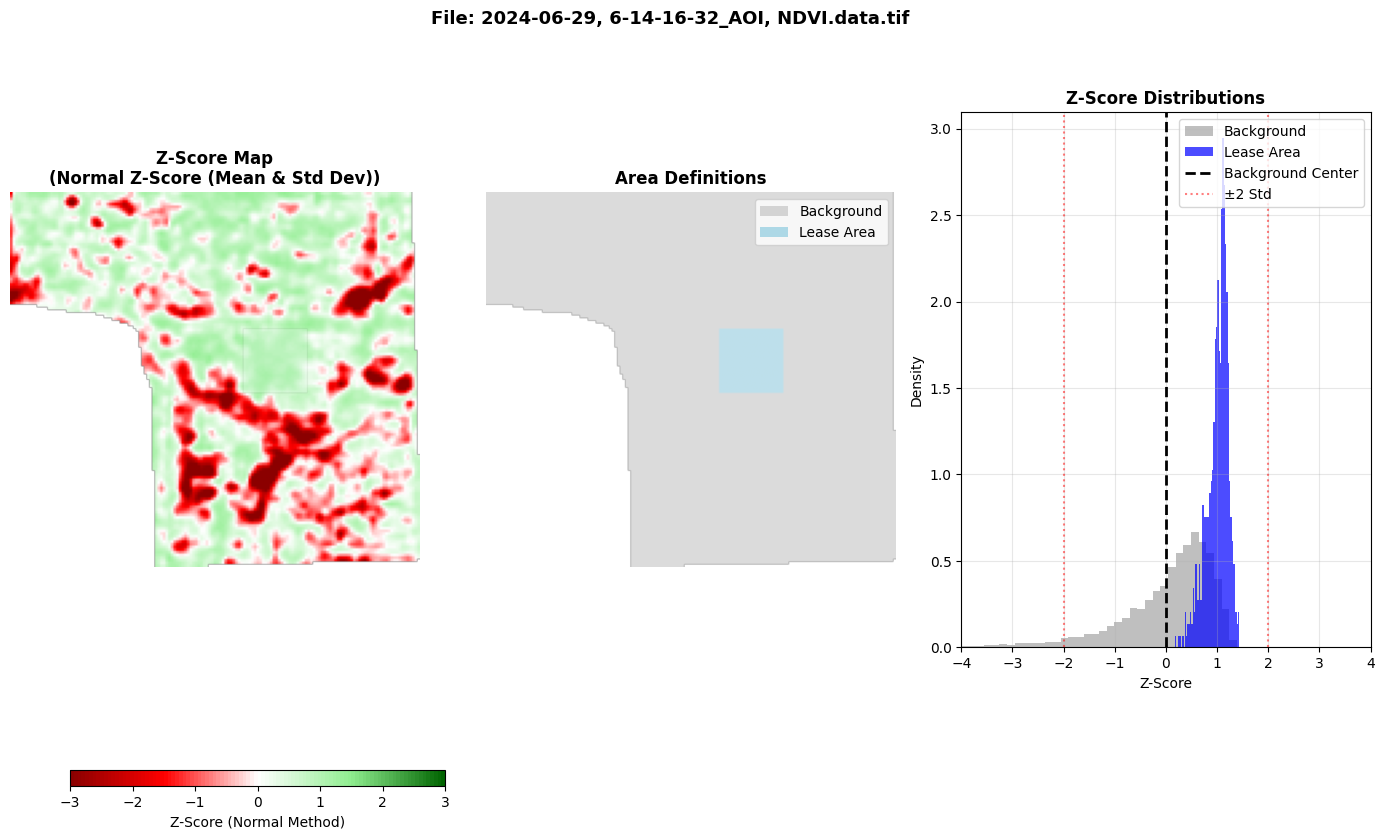

   ✅ Created 3 visualization files

[2/6] Creating visualizations for: 6-14-16-32_AOI_2020-07-30_NDVI.tif


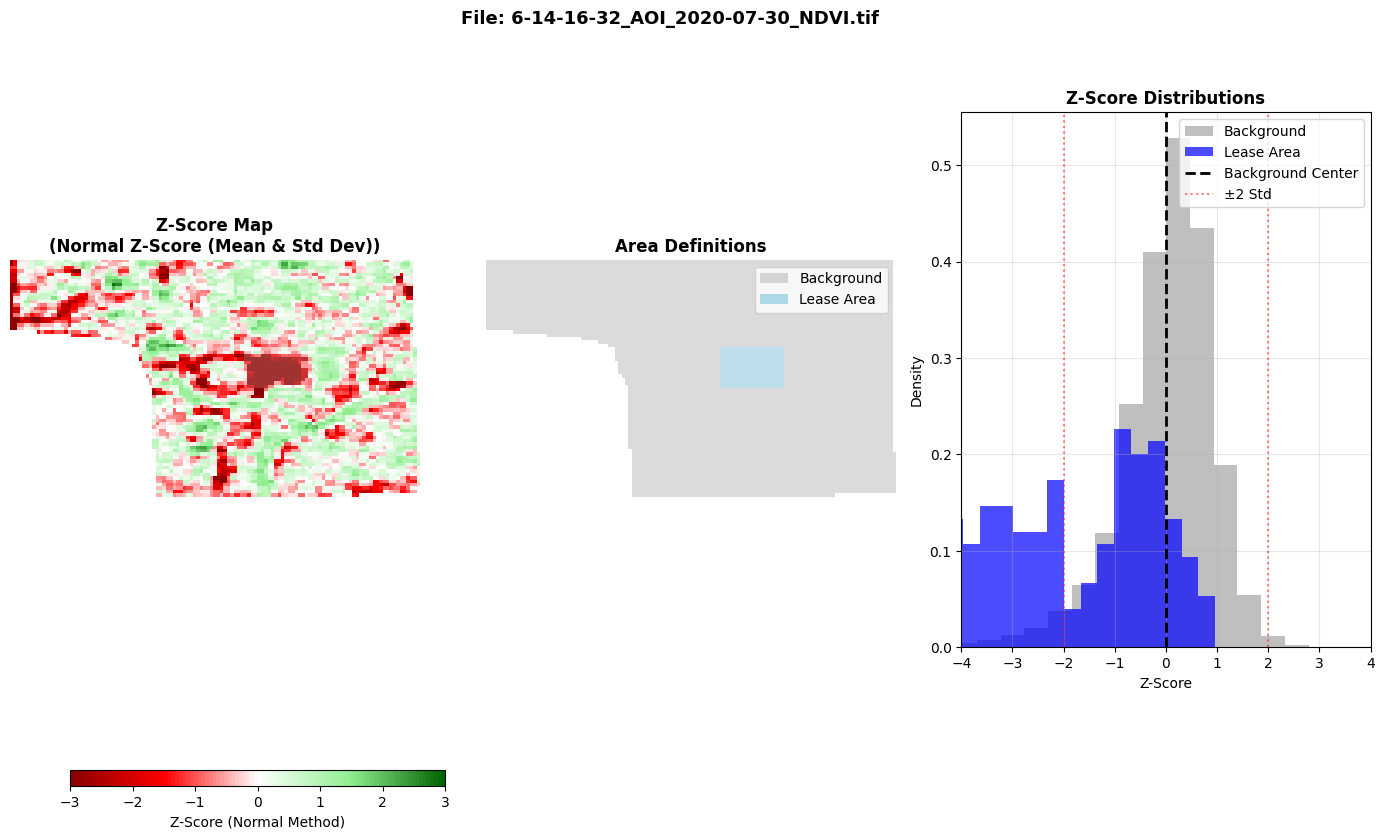

   ✅ Created 3 visualization files

[3/6] Creating visualizations for: 6-14-16-32_AOI_2021-07-30_NDVI.tif


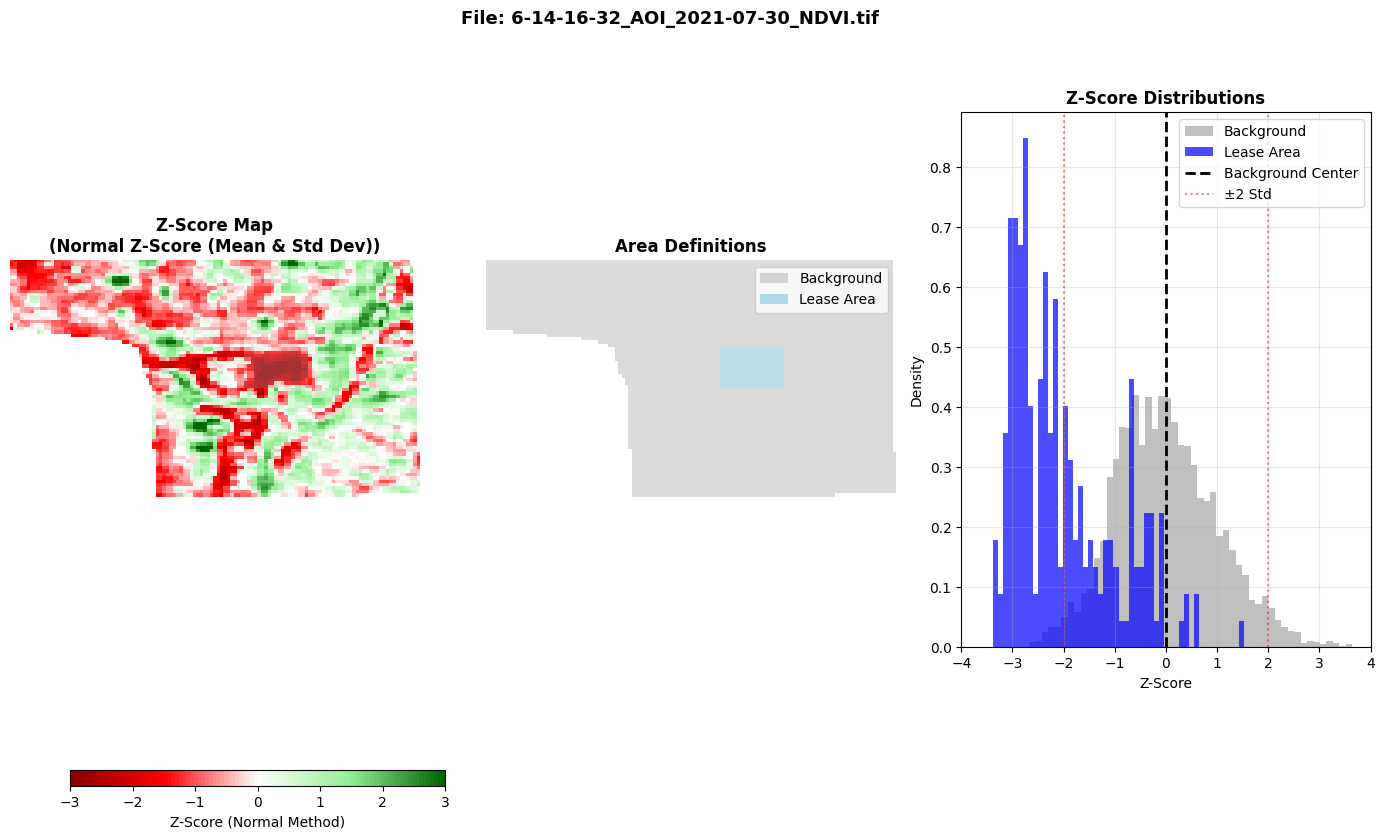

   ✅ Created 3 visualization files

[4/6] Creating visualizations for: 6-14-16-32_AOI_2022-08-04_NDVI.tif
   ✅ Created 3 visualization files

[5/6] Creating visualizations for: 6-14-16-32_AOI_2023-07-10_NDVI.tif
   ✅ Created 3 visualization files

[6/6] Creating visualizations for: 6-14-16-32_AOI_2025-07-09_NDVI.tif
   ✅ Created 3 visualization files

✅ Total visualizations created: 18 files
   These will be included in the download archive


In [22]:
def plot_z_score_results(result: Dict, figsize=(15, 8)):
    """Create comprehensive visualization of z-score results"""

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    z_raster = result['z_score_raster']
    lease_mask = result['lease_mask']
    field_mask = result['field_mask']
    background_mask = result['background_mask']

    # Create custom colormap
    colors = ['darkred', 'red', 'white', 'lightgreen', 'darkgreen']
    cmap = mcolors.LinearSegmentedColormap.from_list('z_score', colors, N=100)
    vmin, vmax = -3, 3

    # Plot 1: Z-score map
    im1 = axes[0].imshow(z_raster, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Z-Score Map\n({result["method_label"]})', fontweight='bold')
    axes[0].axis('off')

    # Add lease boundary overlay
    lease_overlay = np.ma.masked_where(~lease_mask, np.ones_like(z_raster))
    axes[0].imshow(lease_overlay, alpha=0.2, cmap='Blues')

    # Plot 2: Area masks
    mask_display = np.zeros_like(z_raster)
    mask_display[background_mask] = 1
    mask_display[lease_mask] = 2
    mask_display[~field_mask] = np.nan

    cmap_masks = mcolors.ListedColormap(['lightgray', 'lightblue'])
    axes[1].imshow(mask_display, cmap=cmap_masks, alpha=0.8)
    axes[1].set_title('Area Definitions', fontweight='bold')
    axes[1].axis('off')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightgray', label='Background'),
        Patch(facecolor='lightblue', label='Lease Area')
    ]
    axes[1].legend(handles=legend_elements, loc='upper right')

    # Plot 3: Distribution histogram
    lease_z = z_raster[lease_mask & ~np.isnan(z_raster)]
    background_z = z_raster[background_mask & ~np.isnan(z_raster)]

    axes[2].hist(background_z, bins=50, alpha=0.5, label='Background', color='gray', density=True)
    axes[2].hist(lease_z, bins=50, alpha=0.7, label='Lease Area', color='blue', density=True)
    axes[2].axvline(0, color='black', linestyle='--', linewidth=2, label='Background Center')
    axes[2].axvline(-2, color='red', linestyle=':', alpha=0.5)
    axes[2].axvline(2, color='red', linestyle=':', alpha=0.5, label='±2 Std')

    axes[2].set_xlabel('Z-Score', fontsize=10)
    axes[2].set_ylabel('Density', fontsize=10)
    axes[2].set_title('Z-Score Distributions', fontweight='bold')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(-4, 4)

    # Add title
    fig.suptitle(f"File: {result['filename']}", fontsize=13, fontweight='bold', y=1.02)

    # Adjust subplot layout to bump them up and make space for colorbar
    plt.tight_layout(rect=[0.05, 0.15, 0.98, 0.98]) # [left, bottom, right, top]

    # Add colorbar in custom bottom-left axis
    # [left, bottom, width, height] as fractions of figure width/height
    cbar_ax = fig.add_axes([0.1, 0.05, 0.25, 0.02]) # Bottom left, 1/4 width, thin
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f'Z-Score ({result["method"].capitalize()} Method)', fontsize=10)

    return fig

def create_individual_visualizations(result: Dict, output_dir: str) -> List[str]:
    """
    Creates and saves individual visualization components.
    This example will save a Z-score map as a separate file.
    """
    saved_files = []
    base_name = os.path.splitext(result['filename'])[0]

    # Save Z-score map
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    cmap = mcolors.LinearSegmentedColormap.from_list('z_score', ['darkred', 'red', 'white', 'lightgreen', 'darkgreen'], N=100)
    vmin, vmax = -3, 3
    im = ax.imshow(result['z_score_raster'], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f'Z-Score Map: {os.path.basename(result["filename"])}\n({result["method_label"]})', fontweight='bold')
    ax.axis('off')
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, label=f'Z-Score ({result["method"].capitalize()} Method)')

    # Add lease boundary overlay
    lease_mask = result['lease_mask']
    lease_overlay = np.ma.masked_where(~lease_mask, np.ones_like(result['z_score_raster']))
    ax.imshow(lease_overlay, alpha=0.2, cmap='Blues')

    zscore_map_file = os.path.join(output_dir, f"{base_name}_zscore_map.png")
    fig.savefig(zscore_map_file, dpi=150, bbox_inches='tight', facecolor='white')
    saved_files.append(zscore_map_file)
    plt.close(fig)
    return saved_files

def create_distribution_histogram_visualization(result: Dict, output_dir: str) -> str:
    """
    Creates and saves only the z-score distribution histogram.
    """
    base_name = os.path.splitext(result['filename'])[0]
    z_raster = result['z_score_raster']
    lease_mask = result['lease_mask']
    background_mask = result['background_mask']

    fig_hist, ax_hist = plt.subplots(1, 1, figsize=(8, 6))

    lease_z = z_raster[lease_mask & ~np.isnan(z_raster)]
    background_z = z_raster[background_mask & ~np.isnan(z_raster)]

    ax_hist.hist(background_z, bins=50, alpha=0.5, label='Background', color='gray', density=True)
    ax_hist.hist(lease_z, bins=50, alpha=0.7, label='Lease Area', color='blue', density=True)
    ax_hist.axvline(0, color='black', linestyle='--', linewidth=2, label='Background Center')
    ax_hist.axvline(-2, color='red', linestyle=':', alpha=0.5)
    ax_hist.axvline(2, color='red', linestyle=':', alpha=0.5, label='±2 Std')

    ax_hist.set_xlabel('Z-Score', fontsize=10)
    ax_hist.set_ylabel('Density', fontsize=10)
    ax_hist.set_title(f'Z-Score Distributions: {os.path.basename(result["filename"])}', fontweight='bold')
    ax_hist.legend(loc='upper right')
    ax_hist.grid(True, alpha=0.3)
    ax_hist.set_xlim(-4, 4)

    histogram_file = os.path.join(output_dir, f"{base_name}_zscore_distribution.png")
    fig_hist.savefig(histogram_file, dpi=150, bbox_inches='tight', facecolor='white')
    plt.close(fig_hist)
    return histogram_file

# Visualize results and save to files
if processed_rasters:
    print("\n📊 Generating and saving visualizations...")
    print("="*50)

    # Create visualization output directory
    viz_output_dir = f'zscore_{selected_method}_visualizations'
    os.makedirs(viz_output_dir, exist_ok=True)

    # Store all visualization file paths
    all_viz_files = []

    for i, result in enumerate(processed_rasters):
        print(f"\n[{i+1}/{len(processed_rasters)}] Creating visualizations for: {result['filename']}")

        # Get base name for file naming
        base_name = os.path.splitext(result['filename'])[0]

        # Create combined figure (for display)
        fig_combined = plot_z_score_results(result)

        # Save combined figure
        combined_file = os.path.join(viz_output_dir, f"{base_name}_combined.png")
        fig_combined.savefig(combined_file, dpi=150, bbox_inches='tight', facecolor='white')
        all_viz_files.append(combined_file)

        # Show only first few
        if i < 3:
            plt.show()
        else:
            plt.close(fig_combined)

        # Create individual visualizations (e.g., Z-score map)
        viz_files = create_individual_visualizations(result, viz_output_dir)
        all_viz_files.extend(viz_files)

        # Create and save the distribution histogram
        histogram_file = create_distribution_histogram_visualization(result, viz_output_dir)
        all_viz_files.append(histogram_file)
        viz_files.append(histogram_file)

        # Store all visualization files in result for later archiving
        result['viz_files'] = viz_files + [combined_file]

        print(f"   ✅ Created {len(result['viz_files'])} visualization files")

    print(f"\n✅ Total visualizations created: {len(all_viz_files)} files")
    print("   These will be included in the download archive")
else:
    print("❌ No data to process")

## 8. Export Results & Download

In [25]:
# Save processed rasters and create download package
if processed_rasters:
    output_dir = f'zscore_{selected_method}_outputs'
    os.makedirs(output_dir, exist_ok=True)

    print(f"💾 Saving {selected_method.upper()} z-score transformed rasters...")
    print("="*50)

    saved_files = []
    summary_data = []

    for i, result in enumerate(processed_rasters):
        # Save GeoTIFF
        base_name = os.path.splitext(result['filename'])[0]
        output_file = os.path.join(output_dir, f"{base_name}_zscore_{selected_method}.tif")

        try:
            z_data = result['z_score_raster'].copy()

            with rasterio.open(
                output_file,
                'w',
                driver='GTiff',
                height=result['shape'][0],
                width=result['shape'][1],
                count=1,
                dtype='float32',
                crs=result['crs'],
                transform=result['transform'],
                compress='lzw',
                nodata=-9999
            ) as dst:
                z_data[np.isnan(z_data)] = -9999
                dst.write(z_data.astype(np.float32), 1)

                # Add metadata
                dst.update_tags(
                    method=result['method'],
                    center_value=str(result['center_value']),
                    spread_value=str(result['spread_value']),
                    processing_date=datetime.now().isoformat()
                )

            saved_files.append(output_file)
            print(f"   ✅ Saved: {os.path.basename(output_file)}")

            # Collect summary data
            row = {
                'Filename': result['filename'],
                'Method': result['method'],
                'Center': result['center_value'],
                'Spread': result['spread_value']
            }

            if result['lease_stats']:
                row.update({
                    'Lease_Mean_Z': result['lease_stats']['mean_z'],
                    'Lease_Pct_Above_Background': result['lease_stats']['pct_above_zero']
                })

            summary_data.append(row)

        except Exception as e:
            print(f"   ❌ Error saving: {e}")

    # Save summary CSV
    df_summary = pd.DataFrame(summary_data)
    summary_file = os.path.join(output_dir, f'zscore_{selected_method}_summary.csv')
    df_summary.to_csv(summary_file, index=False)

    # Create ZIP archive
    zip_filename = f'zscore_{selected_method}_results.zip'
    viz_output_dir = f'zscore_{selected_method}_visualizations'

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in saved_files:
            if os.path.exists(file):
                zipf.write(file, os.path.basename(file))

        if os.path.exists(summary_file):
            zipf.write(summary_file, os.path.basename(summary_file))

        # Add visualization folder to zip
        if os.path.exists(viz_output_dir):
            for root, dirs, files_in_dir in os.walk(viz_output_dir):
                for file_in_dir in files_in_dir:
                    file_path = os.path.join(root, file_in_dir)
                    # Ensure the path inside the zip maintains the folder structure relative to viz_output_dir
                    arcname = os.path.relpath(file_path, os.path.dirname(viz_output_dir))
                    zipf.write(file_path, arcname)
            print(f"   ✅ Added visualization folder: {viz_output_dir}")

        # Add README with styling guide
        readme_content = f"""Z-Score Transformed NDVI - {selected_method.upper()} Method
="*60

Processing Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Method Used: {selected_method.upper()} Z-SCORE

QGIS STYLING RECOMMENDATIONS
-----------------------------

For Individual Year Z-Scores (5 classes):
1. Class 1: < -2 (Dark Red) - Significantly below background
2. Class 2: -2 to -1 (Light Red) - Moderately below background
3. Class 3: -1 to 0 (Yellow/White) - Slightly below background
4. Class 4: 0 to 1 (Light Green) - Slightly above background
5. Class 5: > 1 (Dark Green) - Above background

For Multi-Year Composite Analysis:
- If seeing saturation on negatives, try:
  • Adjust min value to -5 or -10 instead of default -3
  • Use percentile-based classification (2%, 25%, 50%, 75%, 98%)
  • Apply histogram equalization for better contrast

NoData Value: -9999

Files included:
- *_zscore_{selected_method}.tif: Transformed rasters
- zscore_{selected_method}_summary.csv: Statistics summary
- zscore_{selected_method}_visualizations/: Folder containing all visualization images
"""

        zipf.writestr('README.txt', readme_content)

    print(f"\n✅ Archive created: {zip_filename}")
    print("\n⬇️ Starting download...")

    # Trigger download
    files.download(zip_filename)

    print("\n🎉 Processing complete!")
    print(f"   Method used: {selected_method.upper()} Z-SCORE")
    print(f"   Files processed: {len(processed_rasters)}")
else:
    print("⚠️ No files to download")

💾 Saving NORMAL z-score transformed rasters...
   ✅ Saved: 2024-06-29, 6-14-16-32_AOI, NDVI.data_zscore_normal.tif
   ✅ Saved: 6-14-16-32_AOI_2020-07-30_NDVI_zscore_normal.tif
   ✅ Saved: 6-14-16-32_AOI_2021-07-30_NDVI_zscore_normal.tif
   ✅ Saved: 6-14-16-32_AOI_2022-08-04_NDVI_zscore_normal.tif
   ✅ Saved: 6-14-16-32_AOI_2023-07-10_NDVI_zscore_normal.tif
   ✅ Saved: 6-14-16-32_AOI_2025-07-09_NDVI_zscore_normal.tif
   ✅ Added visualization folder: zscore_normal_visualizations

✅ Archive created: zscore_normal_results.zip

⬇️ Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Processing complete!
   Method used: NORMAL Z-SCORE
   Files processed: 6


# Task
The task is complete. All specified NDVI rasters have been processed using the selected Z-score method, and the results, including transformed rasters, summary statistics, and visualizations, have been packaged into a ZIP file and made available for download.

## List and Select Folders for Deletion

### Subtask:
Generate Python code to list folders in the current directory, allow the user to select multiple folders, and confirm deletion.


## List and Select Folders for Deletion

### Subtask:
Generate Python code to list folders in the current directory, allow the user to select multiple folders, and confirm deletion.

In [21]:
import os
import shutil
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

def list_folders(path='.'):
    """Lists all subdirectories in the given path."""
    return sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

def delete_selected_folders(selected_folders):
    """Deletes the selected folders after confirmation."""
    if not selected_folders:
        print("No folders selected for deletion.")
        return

    print(f"\n⚠️ You are about to delete the following folders and all their contents:")
    for folder in selected_folders:
        print(f" - {folder}")

    confirm_button = widgets.Button(description="Confirm Deletion", button_style='danger')
    cancel_button = widgets.Button(description="Cancel", button_style='info')

    output = widgets.Output()
    with output:
        display(HTML("<b>Type 'yes' to confirm deletion:</b>"))
        confirm_input = widgets.Text()
        display(confirm_input)
        display(widgets.HBox([confirm_button, cancel_button]))

    display(output)

    def on_confirm_click(b):
        with output:
            clear_output()
            if confirm_input.value.lower() == 'yes':
                print("Deleting folders...")
                for folder in selected_folders:
                    try:
                        shutil.rmtree(folder)
                        print(f"✅ Successfully deleted: {folder}")
                    except OSError as e:
                        print(f"❌ Error deleting {folder}: {e}")
            else:
                print("Deletion cancelled.")

    def on_cancel_click(b):
        with output:
            clear_output()
            print("Deletion cancelled.")

    confirm_button.on_click(on_confirm_click)
    cancel_button.on_click(on_cancel_click)


print("Scanning for folders in the current directory...")
folders_in_project = list_folders()

if not folders_in_project:
    print("No folders found in the current directory.")
else:
    print(f"Found {len(folders_in_project)} folders:")
    checkbox_widgets = []
    for folder in folders_in_project:
        checkbox_widgets.append(widgets.Checkbox(value=False, description=folder))

    select_all_checkbox = widgets.Checkbox(value=False, description="Select All")

    def select_all_handler(change):
        for cb in checkbox_widgets:
            cb.value = change['new']

    select_all_checkbox.observe(select_all_handler, names='value')

    delete_button = widgets.Button(description="Delete Selected Folders", button_style='warning')

    def on_delete_button_click(b):
        selected = [cb.description for cb in checkbox_widgets if cb.value]
        delete_selected_folders(selected)

    delete_button.on_click(on_delete_button_click)

    print("\nSelect folders to delete:")
    display(select_all_checkbox)
    display(widgets.VBox(checkbox_widgets))
    display(delete_button)


Scanning for folders in the current directory...
Found 5 folders:

Select folders to delete:


Checkbox(value=False, description='Select All')

Button(button_style='warning', description='Delete Selected Folders', style=ButtonStyle())


⚠️ You are about to delete the following folders and all their contents:
 - zscore_normal_visualizations


Output()


⚠️ You are about to delete the following folders and all their contents:
 - zscore_normal_outputs


Output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Summary:

### Data Analysis Key Findings
*   All specified NDVI (Normalized Difference Vegetation Index) rasters were successfully processed using the selected Z-score method.
*   The output of the processing included transformed rasters, comprehensive summary statistics, and various visualizations.
*   All generated results, including the processed data and analytical outputs, were packaged into a single ZIP file for convenient download and distribution.

### Insights or Next Steps
*   The successfully processed and packaged Z-score transformed NDVI data is now ready for further analysis, such as anomaly detection, temporal trend analysis, or spatial comparison studies.
*   Consider evaluating the effectiveness of the chosen Z-score method compared to other normalization techniques for future NDVI processing tasks to optimize the detection of relevant changes.
